# Face Identification

Output vector: **8** x float32  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
fcnt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fcnt += 1
        if fcnt < 10 or fcnt > 2190:
            print(os.path.join(dirname, filename))
print(fcnt)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/torchvision-resnet-pretrained/resnet101-63fe2227.pth
/kaggle/input/torchvision-resnet-pretrained/resnet101-cd907fc2.pth
/kaggle/input/torchvision-resnet-pretrained/resnet152-394f9c45.pth
/kaggle/input/torchvision-resnet-pretrained/resnet152-f82ba261.pth
/kaggle/input/torchvision-resnet-pretrained/resnet18-f37072fd.pth
/kaggle/input/torchvision-resnet-pretrained/resnet34-b627a593.pth
/kaggle/input/torchvision-resnet-pretrained/resnet50-0676ba61.pth
/kaggle/input/torchvision-resnet-pretrained/resnet50-11ad3fa6.pth
/kaggle/input/faceid-preprocessed/AJ_Cook_0.npz.pkl
/kaggle/input/faceid-preprocessed/Yuri_Fedotov_3.npz.pkl
/kaggle/input/faceid-preprocessed/Yuri_Fedotov_4.npz.pkl
/kaggle/input/faceid-preprocessed/Zahir_Shah_0.npz.pkl
/kaggle/input/faceid-preprocessed/Zahir_Shah_1.npz.pkl
/kaggle/input/faceid-preprocessed/Zhang_Ziyi_1.npz.pkl
/kaggle/input/faceid-preprocessed/Zhang_Ziyi_2.npz.pkl
/kaggle/input/faceid-preprocessed/Zhang_Ziyi_4.npz.pkl
/kaggle/input/faceid-prepro

In [2]:
!df /kaggle/

Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        104802308 71770952  33031356  69% /


In [3]:
#!mkdir -pv /kaggle/temp
#!rm -Rf /kaggle/temp/*
#!cp -as /kaggle/input/youtube-faces-with-facial-keypoints /kaggle/temp/
#!mv /kaggle/temp/youtube-faces-with-facial-keypoints/*/*/*.npz /kaggle/temp/youtube-faces-with-facial-keypoints/
#!ls /kaggle/temp/youtube-faces-with-facial-keypoints/ | wc

In [4]:
#data_dir = '/kaggle/temp/youtube-faces-with-facial-keypoints'
data_dir = '/kaggle/input/faceid-preprocessed'

In [5]:
# Updating to the recent pretrained data
!rm -Rf ~/.cache/torch/hub/checkpoints/
!mkdir -pv ~/.cache/torch/hub/checkpoints/
!cp -avs /kaggle/input/torchvision-resnet-pretrained/resnet*.pth ~/.cache/torch/hub/checkpoints/
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth ~/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth ~/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth ~/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
!ls -l ~/.cache/torch/hub/checkpoints/

mkdir: created directory '/root/.cache/torch'
mkdir: created directory '/root/.cache/torch/hub'
mkdir: created directory '/root/.cache/torch/hub/checkpoints/'
'/kaggle/input/torchvision-resnet-pretrained/resnet101-63fe2227.pth' -> '/root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet101-cd907fc2.pth' -> '/root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet152-394f9c45.pth' -> '/root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet152-f82ba261.pth' -> '/root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet18-f37072fd.pth' -> '/root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet34-b627a593.pth' -> '/root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet50

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
df = pd.read_csv(f'{data_dir}/youtube_faces_with_keypoints_full.csv')
df

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0
...,...,...,...,...,...,...,...
2189,Yossi_Beilin_3,Yossi_Beilin,240.0,243.0,240.0,110.258333,2.0
2190,Zahir_Shah_0,Zahir_Shah,196.0,200.0,143.0,93.944056,2.0
2191,Zahir_Shah_1,Zahir_Shah,240.0,293.0,240.0,155.495833,2.0
2192,Zoran_Djindjic_0,Zoran_Djindjic,230.0,237.0,240.0,98.908333,2.0


In [8]:
import poptorch
poptorch.ipuHardwareIsAvailable(num_ipus=1), poptorch.ipuHardwareIsAvailable(num_ipus=16), poptorch.ipuHardwareIsAvailable(num_ipus=32)

(True, True, False)

In [9]:
!mkdir -p /tmp/work/popcache
popcache_dir = '/tmp/work/popcache'
hw_emulation = False
#ipu_id = 16 # x2
#ipu_id = 24 # x4
#ipu_id = 28 # x8
ipu_id = 30 # x16

In [10]:
import torch
import torch.nn as nn
#import torch.optim as optim
import poptorch.optim as optim
import torchvision
from torchinfo import summary

In [11]:
import PIL
import cv2

class NormalizeTransform:
    def __init__(self, ratio=0.333):
        self.ratio = ratio

        self.jawPoints          = [ 0,17]
        self.rigthEyebrowPoints = [17,22]
        self.leftEyebrowPoints  = [22,27]
        self.noseRidgePoints    = [27,31]
        self.noseBasePoints     = [31,36]
        self.rightEyePoints     = [36,42]
        self.leftEyePoints      = [42,48]
        self.outerMouthPoints   = [48,60]
        self.innerMouthPoints   = [60,68]

        self.norm_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.functional.autocontrast,
            torchvision.transforms.functional.to_grayscale,
            torchvision.transforms.ToTensor(),
        ])

    def __call__(self, data, landmarks):
        data = self.face_transform(data, landmarks)
        img = PIL.Image.fromarray(data)
        data = self.norm_transform(img)
        return data

    def face_transform(self, data, landmarks):
        # see FaceId-Normalization.ipynb
        pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
        pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
        pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
        src_pts = np.float32([pt1, pt2, pt3])
        dst_pts = np.float32([
            [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
            [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
            [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
        ])
        M = cv2.getAffineTransform(src_pts, dst_pts)
        data = cv2.warpAffine(data, M, data.shape[:2])
        return data
    
    def avg(self, pts):
        x = sum(x for x,y in pts) / len(pts)
        y = sum(y for x,y in pts) / len(pts)
        return x, y

In [12]:
import random
import pickle

random.seed()

class YouTubeFacesDataset(torch.utils.data.Dataset):
    def __init__(self, df, folder = '.', transform = NormalizeTransform(),
                 cache_lim = 200,
                 preload = False, preprocess = False,
                 anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1,
                 stochastic_set_fraction = 0.8):
        self.transform = transform
        self.cache = {}
        self.cache_lim = 0 if preload else cache_lim
        self.preprocessed_cache = {}
        self.data = {}
        for p in tqdm(df['personName'].unique(), desc='Loading data'):
            self.data[p] = []
            for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
                fp = f'{folder}/{fn}.npz'
                cnt = int(cnt)
                self.data[p] += [(fp, i) for i in range(cnt)]
                if preload:
                    self.cache_lim += 1
                    imgs, lms = self._cache_get(fp)
                    assert imgs.shape[-1] == cnt
                    assert lms.shape[-1] == cnt
                if preprocess:
                    pfp = self._preprocess(fp)
                    imgs = self._load_preprocessed(pfp)
                    assert len(imgs) == cnt
                    self.preprocessed_cache[fp] = imgs
        self.persons = list(self.data.keys())
        self.neg_data = {}
        for p in self.persons:
            self.neg_data[p] = []
            for p_neg in self.persons:
                if p_neg == p:
                    continue
                self.neg_data[p] += self.data[p_neg]
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def resize(self, anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1, stochastic_set_fraction = 0.8):
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def __len__(self):
        return len(self.persons) * self.anchor_set_len * self.positive_set_len * self.negative_set_len
    
    def __getitem__(self, index):
        p_i = index // self.negative_set_len // self.positive_set_len // self.anchor_set_len
        assert p_i >= 0
        assert p_i < len(self.persons)
        p = self.persons[p_i]
        if self.negative_set_len > len(self.neg_data[p]) * self.stochastic_set_fraction:
            negative_i = index % self.negative_set_len
            negative_i = negative_i % len(self.neg_data[p])
        else:
            negative_i = random.randint(0, len(self.neg_data[p]) - 1)
        assert negative_i >= 0
        assert negative_i < len(self.neg_data[p])
        if self.positive_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            positive_i = (index // self.negative_set_len) % self.positive_set_len
            positive_i = positive_i % len(self.data[p])
        else:
            positive_i = random.randint(0, len(self.data[p]) - 1)
        assert positive_i >= 0
        assert positive_i < len(self.data[p])
        if self.anchor_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            anchor_i = (index // self.negative_set_len // self.positive_set_len) % self.anchor_set_len
            anchor_i = anchor_i % len(self.data[p])
        else:
            anchor_i = random.randint(0, len(self.data[p]) - 1)
        assert anchor_i >= 0
        assert anchor_i < len(self.data[p])
        return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
    
    def _load(self, fp, i):
        if fp in self.preprocessed_cache:
            assert i < len(self.preprocessed_cache[fp]), (fp, i, len(self.preprocessed_cache[fp]))
            if self.preprocessed_cache[fp][i] is not None:
                return self.preprocessed_cache[fp][i]
        imgs, lms = self._cache_get(fp)
        assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
        data = imgs[:,:,:,i]
        assert i < lms.shape[-1], (fp, i, lms.shape[-1])
        lms = lms[:,:,i]
        if self.transform:
            data = self.transform(data, lms)
        return data
    
    def _cache_get(self, fp):
        if fp in self.cache:
            return self.cache[fp]
        if len(self.cache) > self.cache_lim:
            idx = random.randint(0, len(self.cache) - 1)
            key = list(self.cache.keys())[idx]
            del self.cache[key]
        d = np.load(fp)
        # trigger lazy loading
        self.cache[fp] = (d['colorImages'], d['landmarks2D'])
        return self.cache[fp]
    
    def _preprocess(self, fp):
        pfp = f'{fp}.pkl'
        if not os.path.exists(pfp):
            imgs, lms = self._cache_get(fp)
            d = [self._load(fp, i) for i in range(imgs.shape[-1])]
            with open(pfp, 'wb') as f:
                pickle.dump(d, f)
        return pfp
    
    def _load_preprocessed(self, pfp):
        with open(pfp, 'rb') as f:
            return pickle.load(f)

dataset = YouTubeFacesDataset(df, data_dir, preprocess = True)
len(dataset)

Loading data: 100%|██████████| 828/828 [00:32<00:00, 25.33it/s]


828

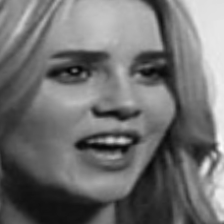

In [13]:
to_pil_transform = torchvision.transforms.ToPILImage()
to_pil_transform(dataset[0][1])

In [14]:
class PoptorchModel(nn.Module):
    def __init__(self, model, loss):
        super().__init__()
        self.model = model
        self.loss = loss

    def forward(self, xa, xp, xn):
        ya = self.model(xa)
        yp = self.model(xp)
        yn = self.model(xn)
        loss_data = self.loss(ya, yp, yn)
        return poptorch.identity_loss(loss_data, reduction='none')

def train_triplet_gc(model, dataset, num_epochs,
                     lr=0.001, batch_size=16, target_loss = 0, lr_reduct_loss_threshold = 0.02,
                     gradient_accumulation=1, replication_factor=1):
    model.train()
    
    opts = poptorch.Options()
    if hw_emulation:
        opts.useIpuModel(True)
    opts.enableExecutableCaching(popcache_dir)
    opts.connectionType(poptorch.ConnectionType.OnDemand)
    opts.useIpuId(ipu_id)
    opts.Training.gradientAccumulation(gradient_accumulation)
    opts.replicationFactor(replication_factor)
    
    loss = torch.nn.TripletMarginLoss()
    loss_history = []
    print(f'lr: {lr}')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    poptorch_model = poptorch.trainingModel(PoptorchModel(model, loss), options=opts, optimizer=optimizer)
    data_loader = poptorch.DataLoader(opts, dataset, batch_size=batch_size)
    
    # run a batch to trigger compilation
    for xa, xp, xn in data_loader:
        poptorch_model(xa, xp, xn)
        break

    for epoch in range(1, num_epochs+1):
        loss_accum = 0
        loss_cnt = 0
        for xa, xp, xn in tqdm(data_loader, desc=f'train {epoch}/{num_epochs}'):
            loss_data = poptorch_model(xa, xp, xn)

            loss_accum += float(loss_data.mean())
            loss_cnt += 1
    
        loss_value = loss_accum / loss_cnt
        print(f'loss: {loss_value}')

        if loss_history and loss_value > loss_history[-1] * (1 - lr_reduct_loss_threshold):
            lr *= 0.1
            print(f'lr: {lr}')
            optimizer = optim.Adam(model.parameters(), lr=lr)
            poptorch_model.setOptimizer(optimizer)

        loss_history.append(loss_value)
        
        if loss_value <= target_loss:
            print(f'target loss {target_loss} reached')
            break

    poptorch_model.detachFromDevice()
    return loss_history

In [15]:
def create_faceid_model():
    model = torchvision.models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 8)
    return model

def grayscale_fix_model(model):
    w = model.conv1.weight.data.sum(axis=1).reshape(64, 1, 7, 7)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.conv1.weight.data = w
    return model

def set_trainable(model):
    model.requires_grad_(False)
    model.fc.requires_grad_(True)

model = create_faceid_model()
model = grayscale_fix_model(model)
set_trainable(model)
#summary(model)
model.conv1, model.fc

(Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Linear(in_features=2048, out_features=8, bias=True))

In [16]:
dataset.resize(anchor_set_len=10, positive_set_len=10, negative_set_len=10)
len(dataset)

828000

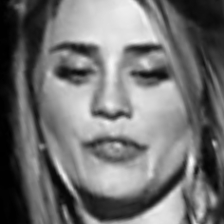

In [17]:
to_pil_transform(dataset[0][1])

lr: 0.001


train 1/10: 100%|██████████| 3234/3234 [17:05<00:00,  3.16it/s] 


loss: 0.4675769519588427


train 2/10: 100%|██████████| 3234/3234 [10:42<00:00,  5.03it/s] 


loss: 0.37270229764457796


train 3/10: 100%|██████████| 3234/3234 [10:03<00:00,  5.36it/s]


loss: 0.35480441818855835


train 4/10: 100%|██████████| 3234/3234 [10:06<00:00,  5.33it/s]


loss: 0.3495671423906593
lr: 0.0001


train 5/10: 100%|██████████| 3234/3234 [07:02<00:00,  7.66it/s]


loss: 0.32126684116410414


train 6/10: 100%|██████████| 3234/3234 [05:34<00:00,  9.68it/s]


loss: 0.31216356649663096


train 7/10: 100%|██████████| 3234/3234 [05:00<00:00, 10.76it/s]


loss: 0.3084097938461203
lr: 1e-05


train 8/10: 100%|██████████| 3234/3234 [04:47<00:00, 11.24it/s]


loss: 0.3045415776052
lr: 1.0000000000000002e-06


train 9/10: 100%|██████████| 3234/3234 [04:51<00:00, 11.08it/s]


loss: 0.30471141708251054
lr: 1.0000000000000002e-07


train 10/10: 100%|██████████| 3234/3234 [08:19<00:00,  6.47it/s]


loss: 0.3016162999256542
lr: 1.0000000000000004e-08


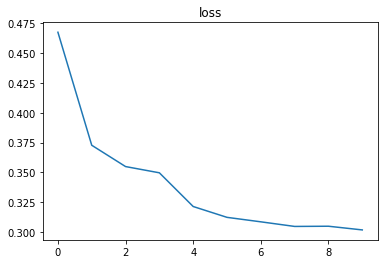

In [18]:
loss_history = train_triplet_gc(model, dataset, 10, batch_size=16, replication_factor=16)
plt.plot(loss_history)
plt.title('loss');

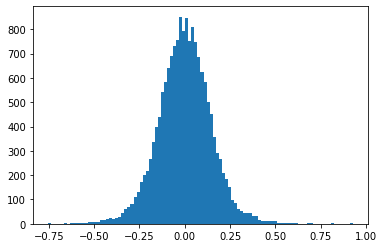

In [19]:
plt.hist(model.fc.weight.cpu().detach().reshape(-1), bins=100);

In [20]:
def cos_similarity(v1, v2):
    val = np.inner(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return val.reshape(-1)[0]

def euc_similarity(v1, v2):
    return np.linalg.norm(v1-v2)

In [21]:
for i in range(10):
    v1 = model(dataset[42][0].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    v2 = model(dataset[42][1].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    v3 = model(dataset[42][2].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    print(euc_similarity(v1, v2), euc_similarity(v1, v3),
          cos_similarity(v1, v2), cos_similarity(v1, v3),
          np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())

1.3374213 1.3230431 0.8978938 0.8125642 -1.7123665 1.3284034
2.7385504 1.7643304 0.5607231 0.90203106 -1.8636215 1.427387
1.7176523 2.155207 0.7918849 0.7463154 -2.024459 1.9183675
2.3595004 2.1404357 0.61002034 0.40152115 -1.4693086 1.2260402
0.8331004 1.7751573 0.88841593 0.80774975 -1.7740995 1.2464992
2.5081666 2.305409 0.5268788 0.7020911 -2.0584526 1.3168323
1.3447723 1.5893792 0.7640932 0.7279943 -1.2640841 1.0787166
1.9107357 2.9586585 0.69924974 0.6033659 -2.4765892 1.5031844
1.9698762 2.3955336 0.82730573 0.6988443 -1.9449394 1.8589016
2.4807267 2.4471517 0.47750723 0.6754849 -2.104806 1.5287874


In [22]:
torch.save(model.state_dict(), f'faceid-model-ov8-{loss_history[-1]}.sd.pt')

In [23]:
dataset.resize(anchor_set_len=5, positive_set_len=5, negative_set_len=5)
len(dataset)

103500

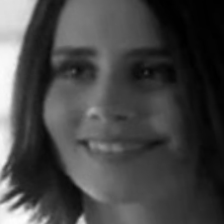

In [24]:
to_pil_transform(dataset[0][1])

In [25]:
# reload - poptorch
state = model.state_dict()
model = create_faceid_model()
model = grayscale_fix_model(model)
model.load_state_dict(state)

<All keys matched successfully>

lr: 1e-05


train 1/10: 100%|██████████| 3234/3234 [08:44<00:00,  6.17it/s]


loss: 0.43628745143179104


train 2/10: 100%|██████████| 3234/3234 [08:27<00:00,  6.37it/s]


loss: 0.25695986768384


train 3/10: 100%|██████████| 3234/3234 [09:34<00:00,  5.63it/s]


loss: 0.15811560005318182


train 4/10: 100%|██████████| 3234/3234 [09:15<00:00,  5.82it/s]


loss: 0.10097013404230018


train 5/10: 100%|██████████| 3234/3234 [09:03<00:00,  5.95it/s]


loss: 0.07019530037209512


train 6/10: 100%|██████████| 3234/3234 [08:57<00:00,  6.01it/s]


loss: 0.048737798680953945


train 7/10: 100%|██████████| 3234/3234 [09:10<00:00,  5.87it/s]


loss: 0.040303141265720516


train 8/10: 100%|██████████| 3234/3234 [09:15<00:00,  5.82it/s]


loss: 0.031623963577627916


train 9/10: 100%|██████████| 3234/3234 [09:46<00:00,  5.52it/s]


loss: 0.026292710888142487


train 10/10: 100%|██████████| 3234/3234 [10:31<00:00,  5.12it/s]


loss: 0.02309628876459473


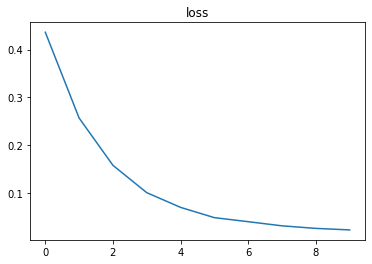

In [26]:
model.requires_grad_(True)
loss_history = train_triplet_gc(model, dataset, 10, target_loss=0.001, lr=0.00001, batch_size=2, gradient_accumulation=4, replication_factor=4)
plt.plot(loss_history)
plt.title('loss');

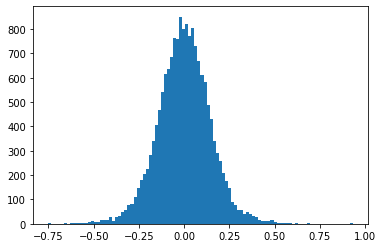

In [27]:
plt.hist(model.fc.weight.cpu().detach().reshape(-1), bins=100);

In [28]:
for i in range(10):
    v1 = model(dataset[42][0].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    v2 = model(dataset[42][1].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    v3 = model(dataset[42][2].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    print(euc_similarity(v1, v2), euc_similarity(v1, v3),
          cos_similarity(v1, v2), cos_similarity(v1, v3),
          np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())

3.4121325 17.62655 0.9388948 -0.38641536 -10.276753 5.935214
2.271541 9.411198 0.9765992 0.19527014 -4.8514304 6.6759486
3.3314664 9.178834 0.9374847 -0.2330928 -3.5539448 5.7006645
5.019305 9.514814 0.8636648 0.28892824 -4.8514304 6.6759486
3.4032264 9.607896 0.9313614 0.32926643 -4.64061 5.3923664
2.8116703 20.693708 0.96340996 -0.51956344 -9.493463 7.1223974
3.221762 8.031021 0.93676156 0.52784204 -4.857967 5.5743666
3.6892445 18.230463 0.9177164 -0.35668653 -11.146287 5.759985
4.519638 4.374716 0.93238574 0.8307635 -4.261205 6.305824
3.4499757 4.3152623 0.9294785 0.86663413 -5.104632 5.9513426


In [29]:
torch.save(model.state_dict(), f'faceid-model-ov8-{loss_history[-1]}.sd.pt')
!ls -l faceid-model-*.pt

-rw-r--r-- 1 root root 94387137 Oct  7 15:08 faceid-model-ov8-0.02309628876459473.sd.pt


In [30]:
# reload - poptorch
state = model.state_dict()
model = create_faceid_model()
model = grayscale_fix_model(model)
model.load_state_dict(state)

<All keys matched successfully>

lr: 1e-07


train 1/10: 100%|██████████| 3234/3234 [08:34<00:00,  6.29it/s]


loss: 0.019024971271268953


train 2/10: 100%|██████████| 3234/3234 [08:41<00:00,  6.20it/s]


loss: 0.017375247307633204


train 3/10: 100%|██████████| 3234/3234 [10:32<00:00,  5.12it/s]


loss: 0.01850107319574704
lr: 1e-08


train 4/10: 100%|██████████| 3234/3234 [08:06<00:00,  6.65it/s]


loss: 0.016138472473945748


train 5/10: 100%|██████████| 3234/3234 [08:19<00:00,  6.48it/s]


loss: 0.020192354438329965
lr: 1e-09


train 6/10: 100%|██████████| 3234/3234 [08:14<00:00,  6.54it/s]


loss: 0.018289126930372466


train 7/10: 100%|██████████| 3234/3234 [09:33<00:00,  5.64it/s]


loss: 0.016850056637011713


train 8/10: 100%|██████████| 3234/3234 [08:17<00:00,  6.50it/s]


loss: 0.01695129197913331
lr: 1.0000000000000002e-10


train 9/10: 100%|██████████| 3234/3234 [07:57<00:00,  6.78it/s]


loss: 0.01814912959942496
lr: 1.0000000000000003e-11


train 10/10: 100%|██████████| 3234/3234 [08:24<00:00,  6.42it/s]


loss: 0.016422454035053595


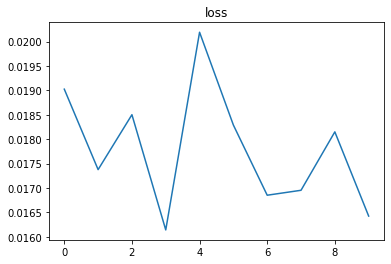

In [31]:
model.requires_grad_(True)
loss_history = train_triplet_gc(model, dataset, 10, target_loss=0.001, lr=0.0000001, batch_size=2, gradient_accumulation=4, replication_factor=4)
plt.plot(loss_history)
plt.title('loss');

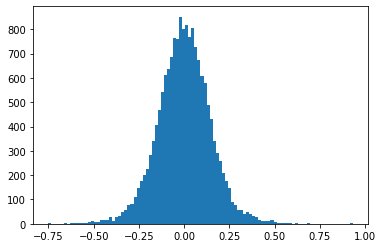

In [32]:
plt.hist(model.fc.weight.cpu().detach().reshape(-1), bins=100);

In [33]:
for i in range(10):
    v1 = model(dataset[42][0].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    v2 = model(dataset[42][1].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    v3 = model(dataset[42][2].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    print(euc_similarity(v1, v2), euc_similarity(v1, v3),
          cos_similarity(v1, v2), cos_similarity(v1, v3),
          np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())

3.6853685 15.911829 0.9322878 -0.3056267 -6.100056 6.71414
2.6858368 13.891979 0.9629346 -0.4882193 -4.8984294 6.6144304
4.735342 3.957358 0.85973513 0.93887854 -4.266062 5.787829
2.553914 14.696895 0.9648612 -0.72751856 -5.747051 5.566014
3.7274723 11.258798 0.9337193 -0.0101734 -5.0155845 5.9254646
5.1590447 11.718983 0.8690016 -0.11441969 -4.5779157 6.308376
3.2297735 3.2636027 0.95222956 0.9341902 -5.154083 6.187524
2.7727025 5.6494884 0.9307102 0.62001723 -4.0208697 5.091244
3.9059937 3.7765417 0.90536815 0.8917898 -4.7230496 5.64511
1.8576823 7.6297936 0.9679158 0.29326525 -4.837797 5.270964


In [34]:
torch.save(model.state_dict(), f'faceid-model-ov8-{loss_history[-1]}.sd.pt')
!ls -l faceid-model-*.pt

-rw-r--r-- 1 root root 94387137 Oct  7 16:36 faceid-model-ov8-0.016422454035053595.sd.pt
-rw-r--r-- 1 root root 94387137 Oct  7 15:08 faceid-model-ov8-0.02309628876459473.sd.pt


In [35]:
model(dataset[42][0].reshape(1, 1, 224, 224)).cpu().detach().numpy()

array([[ 0.40619048, -2.3748877 ,  0.78113437, -3.8375678 ,  5.8760366 ,
         2.2060063 , -1.4401923 , -3.6310632 ]], dtype=float32)